In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

## We need a function that takes fluxes and returns Peierls phases.

In [286]:
def vector_potential(Nx,Ny,fluxes, gauge = "C4"):
    '''Returns Peierls phases on the edges of a rectangular square lattice of dimensions (Nx,Ny) given an array of fluxes through each unit cell.
       - Nx: int
       - Ny: int
       - fluxes: ndarray(Nx, Ny)
       - gauge: "Landau" or "C4"
        Returns:
       - a_e
       - a_n'''
    
    # We are assuming a gauge in which A is zero along all edges except at the top one,
    # where it is equal -total_flux/Nx. This should produce the ordinary magnetic translations exp(1j*B*Ny*x).

    def index(direction, i,j):
        '''Returns the index of a Peierls phase in order: direction, xdir, ydir.'''
        if i < Nx and j < Ny:              # first all the hoppings in the unit cell
            idx = (j*Nx+i)*2 + direction 
        elif j == Ny:                       # then all hoppings on the top edge
            idx = 2*Nx*Ny+i
        elif i == Nx:                       # then all hoppings on the right edge
            idx = 2*Nx*Ny+Nx+j
        return idx
    #There are 2*Nx*Ny+Nx+Ny unknowns (all possible values of idx)

    
    row = []
    col = []
    data = []
    rhs = []

    row_i = 0

    # Rotational equations: Nx*Ny equations. These equations are always necessary to have the correct magnetic field
    for i in range(Nx):
        for j in range(Ny):
            row += [row_i]*4 #Equation number row_i(+1)
            col += [index(0,i,j),index(1,i+1,j),index(0,i,j+1),index(1,i,j)] #Unknowns
            data += [1,1,-1,-1] #Coefficients
            rhs += [fluxes[j,i]] #Right-hand side
            
            row_i += 1

    # The following equations fix the gauge
    # Divergence equations (not at the edges): Coulomb gauge: : (Nx-1)*(Ny-1) equations
    for i in range(1,Nx):
        for j in range(1,Ny):
            row += [row_i]*4 #Equation number row_i(+1)
            col += [index(0,i,j), index(1,i,j), index(0,i-1,j), index(1,i,j-1)] #Unknowns
            data += [1,1,-1,-1] #Coefficients
            rhs += [0] #Right-hand side
            
            row_i += 1
            
    #Fix the value of A at the edges
    total_flux = np.sum(fluxes)
    if gauge == "Landau":
        for i in range(Nx): #bottom edge: Nx equations
            row += [row_i]
            col += [index(0,i,0)]
            data += [1]
            rhs += [total_flux/Nx/2]
            row_i += 1
    
        for j in range(Ny): #left edge: Ny equations
            row += [row_i]
            col+= [index(1,0,j)]
            data += [1]
            rhs += [0]
            row_i += 1
    
        for i in range(Nx-1): #top edge: Nx-1 equations
            row += [row_i]
            col+= [index(0,i,Ny)]
            data += [-1]
            rhs += [total_flux/Nx/2]
            row_i += 1
    
        for j in range(Ny): #right edge: Ny equations
            row += [row_i]
            col += [index(1,Nx,j)]
            data += [1]
            rhs += [0]
            row_i += 1
            
    elif gauge == "C4":
        for i in range(Nx): #bottom edge: Nx equations
            row += [row_i]
            col += [index(0,i,0)]
            data += [1]
            rhs += [total_flux/(Nx+Ny)/2]
            row_i += 1
    
        for j in range(Ny): #left edge: Ny equations
            row += [row_i]
            col+= [index(1,0,j)]
            data += [-1]
            rhs += [total_flux/(Nx+Ny)/2]
            row_i += 1
    
        for i in range(Nx-1): #top edge: Nx-1 equations
            row += [row_i]
            col+= [index(0,i,Ny)]
            data += [-1]
            rhs += [total_flux/(Nx+Ny)/2]
            row_i += 1
    
        for j in range(Ny): #right edge: Ny equations
            row += [row_i]
            col += [index(1,Nx,j)]
            data += [1]
            rhs += [total_flux/(Nx+Ny)/2]
            row_i += 1
    else:
        raise ValueError("Choose a valid gauge: 'Landau' or 'C4'")
        
    equations = csr_matrix((data, (row, col)), shape=(2*Nx*Ny+Nx+Ny, 2*Nx*Ny+Nx+Ny))
    vector_potential = sla.spsolve(equations, rhs)
    a_in = vector_potential[:2*Nx*Ny].reshape(Ny,Nx,2)
    a_top = vector_potential[2*Nx*Ny:2*Nx*Ny+Nx].reshape(1,Nx)
    a_right = vector_potential[2*Nx*Ny+Nx:].reshape(Ny,1)

    a_e = np.concatenate([a_in[:,:,0],a_top],axis = 0)
    a_n = np.concatenate((a_in[:,:,1],a_right),axis = 1)
    
    return a_e, a_n

def plot_A(a_e,a_n):
    Nx = len(a_e[0])
    Ny = len(a_n[:,0])
    
    # Define a grid of points
    x = np.linspace(0, Nx, Nx) 
    y = np.linspace(0, Ny, Ny)  
    X, Y = np.meshgrid(x, y)    # Create a meshgrid for plotting
    
    # Create the quiver plot
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111)
    ax.quiver(X, Y, a_e[:-1,:], a_n[:,:-1],np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2), cmap="plasma") #The right and top edges are left out of the plot
    #ax.streamplot(X, Y, a_e[:-1,:], a_n[:,:-1],color=np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2), cmap="plasma") #The right and top edges are left out of the plot
    ax.set_aspect('equal')
    # Step 5: Customize the plot (optional)
    ax.set_xlim([-1, Nx+1])
    ax.set_ylim([-1, Ny+1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Vector Potential')

def plot_B(fluxes):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111)
    ax.imshow(fluxes,vmin = np.min(fluxes),vmax = np.max(fluxes),origin ='lower')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Magnetic field')

def recover_field(a_e, a_n):
    Nx = len(a_e[0])
    Ny = len(a_n[:,0])

    recover_flux = np.zeros((Ny,Nx))
    for i in range(Nx):
        for j in range(Ny):
            recover_flux[j,i] = a_e[j,i] + a_n[j,i+1] - a_e[j+1,i] - a_n[j,i]
    return recover_flux

4.521123059264553e-16


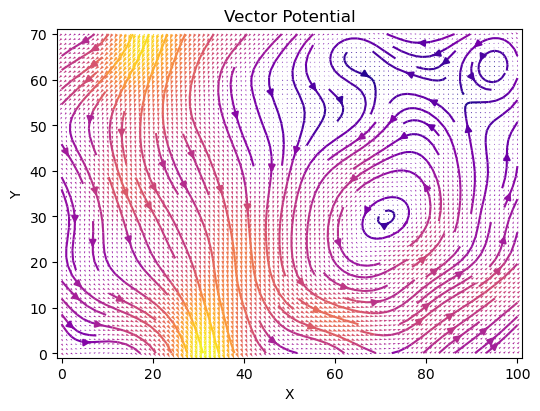

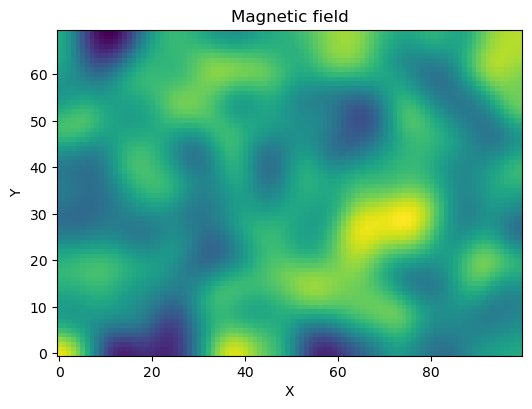

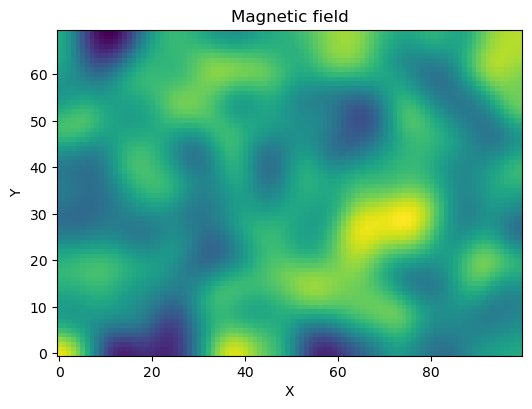

In [285]:
nx = 100
ny = 70
uniform = 2*pi/(nx*ny) #One flux quantum in the system
noise = 100*uniform


fluxes = uniform*np.ones((ny,nx))+noise*(np.random.rand(ny,nx)-np.ones((ny,nx))/2)

from scipy.ndimage import gaussian_filter
fluxes = gaussian_filter(fluxes, sigma=np.sqrt(nx*ny)/20)

a_e, a_n = vector_potential(nx,ny,fluxes, gauge = "C4")

plot_A(a_e,a_n)
recover_flux = recover_field(a_e,a_n)
print(np.max(fluxes- recover_flux))
plot_B(fluxes)
plot_B(recover_flux)

In [291]:
a_e, a_n = vector_potential(nx,ny,fluxes, gauge = "Landau")
plot_A(a_e,a_n)

ValueError: Choose a valid gauge: 'Landau' or 'C4'

/tmp/ipykernel_97323/738098571.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


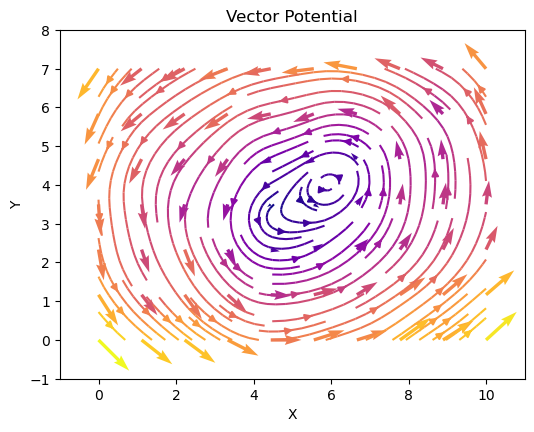

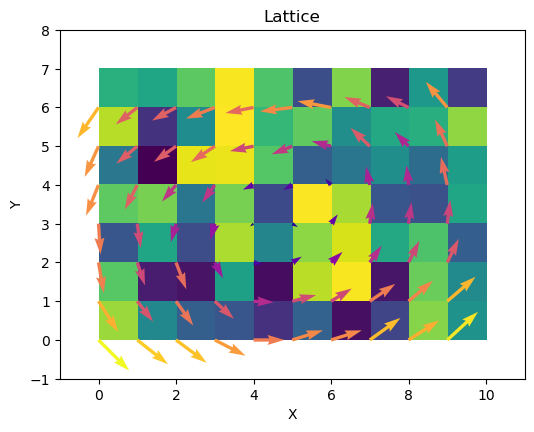

In [295]:
Lx = 10
Ly = 7
fluxes = np.random.rand(Ly,Lx)/1000
a_e, a_n = vector_potential(Lx,Ly,fluxes, gauge = "C4")
plot_A(a_e,a_n)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
# Define a grid of points
x = np.linspace(0, Lx-1, Lx) 
y = np.linspace(0, Ly-1, Ly)  
X, Y = np.meshgrid(x, y)    # Create a meshgrid for plotting
ax.quiver(X, Y, a_e[:-1,:], a_n[:,:-1],np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2), cmap="plasma") #The right and top edges are left out of the plot
ax.imshow(fluxes,extent=[0, Lx, 0, Ly],zorder = -2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-1,Lx+1)
ax.set_ylim(-1,Ly+1)
ax.set_aspect('equal')
ax.set_title('Lattice')
fig.show()